In [1]:
# find rotors in molecule
import re, sys, os
import quaternion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

sys.path.insert(0, '../../karlib')
import chem_subs as chem
import gaussian_subs as gau

In [9]:
molec = 'phcooh'

In [10]:
fgau = r'./geomfreq/{:s}_geom.out'.format(molec)
fgjf = fgau.replace('.out', '.gjf')
FGAU = open(fgau, 'r') 

In [11]:
# it should be a geom+freq Gaussian output; get the first optimized coordinates
dfxyz = gau.read_optimized_coordinates(FGAU)[0]
Geom = chem.LabeledGeometry(dfxyz, intype='DataFrame')
tors = Geom.find_terminal_rotors()

In [12]:
# create Gaussian input files to find torsional saddle points
ginput = gau.GauInput(fgjf)  # geometry optimization (minimum) + frequencies
# change keywords
ginput.set_keyword('opt', ['TS', 'calcfc'], add=True)
ginput.set_keyword('symm', 'delete')  # drop any 'symm=loose' directive
# retain only the 'method/basis" part of the comment
wcom = ginput.comment.split()
comment = ' '.join([w for w in wcom if '/' in w])
ginput.comment = comment

In [13]:
G = Geom.copy()

In [14]:
# set nprocs=2 for running on PC
ginput.set_pct({'nprocs': 2})

([0, 6], [[1, 2, 3, 4, 5, 9, 10, 11, 12, 13], [7, 8, 14]])
Rotor is CHO2


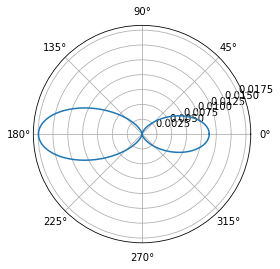

Highest point near phi = 179 degrees
Rotor multiplicity = 1
15
molecular composition is C7H6O2
C	   0.00074	   0.21981	   0.00000
C	   1.27629	  -0.34851	   0.00000
C	   1.42269	  -1.72731	   0.00000
C	   0.29733	  -2.54640	   0.00000
C	  -0.97500	  -1.98443	   0.00000
C	  -1.12668	  -0.60448	   0.00000
C	  -0.10395	   1.70137	   0.00000
O	  -1.13854	   2.32254	  -0.00865
O	   1.10204	   2.32154	   0.01091
H	   2.13667	   0.30507	   0.00000
H	   2.41166	  -2.16469	   0.00000
H	   0.41216	  -3.62210	   0.00000
H	  -1.84875	  -2.62163	   0.00000
H	  -2.11189	  -0.16309	   0.00000
H	   0.92280	   3.27150	   0.00993

Writing file phcooh_torTS_1.gjf
([6, 8], [[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13], [14]])
Rotor is HO


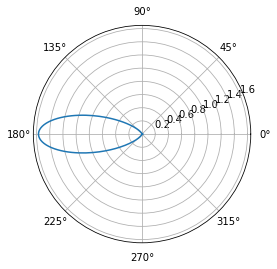

Highest point near phi = 179 degrees
Rotor multiplicity = 1
15
molecular composition is C7H6O2
C	   0.00074	   0.21981	   0.00000
C	   1.27629	  -0.34850	   0.00000
C	   1.42269	  -1.72731	   0.00000
C	   0.29733	  -2.54640	   0.00000
C	  -0.97500	  -1.98443	   0.00000
C	  -1.12668	  -0.60448	   0.00000
C	  -0.10395	   1.70137	   0.00000
O	   0.83304	   2.46187	   0.00000
O	  -1.38522	   2.14577	   0.00000
H	   2.13667	   0.30507	   0.00000
H	   2.41166	  -2.16469	   0.00000
H	   0.41216	  -3.62210	   0.00000
H	  -1.84875	  -2.62163	   0.00000
H	  -2.11189	  -0.16310	   0.00000
H	  -1.94874	   1.36032	  -0.00811

Writing file phcooh_torTS_2.gjf


In [15]:
freets = G.free_torsions()
ngrid = 360
for ifree, freet in enumerate(freets):
    print(freet)
    # choose to rotate the smaller piece
    if len(freet[1][0]) <= len(freet[1][1]):
        irot = 0
    else:
        irot = 1
    srot = chem.formula([G.atom[i].el for i in [freet[0][irot], *freet[1][irot]]])
    print('Rotor is {:s}'.format(srot))
    iaxle, ihub = freet[0][1-irot], freet[0][irot]
    ispokes = freet[1][irot]
    phi = np.linspace(0, 2*np.pi, ngrid)
    profile = np.array([G.rotateTorsion(ispokes, ihub, iaxle, a).steric_pseudoenergy() for a in phi])
    plt.polar(phi, profile-profile.min())
    plt.show()
    imax = np.argmax(profile)
    amax = phi[imax]
    print('Highest point near phi = {:.0f} degrees'.format(np.rad2deg(amax)))
    peaks, _ = find_peaks(profile)
    mult = len(peaks)
    print(f'Rotor multiplicity = {mult}')
    Gcopy = G.rotateTorsion(ispokes, ihub, iaxle, amax)
    Gcopy.printXYZ()
    fgjf = '{:s}_torTS_{:d}.gjf'.format(molec, ifree+1)
    ginput.set_geometry(Gcopy)
    print(f'Writing file {fgjf}')
    ginput.comment = comment + ' TS for {:d}-fold torsion #{:d} ({:s})'.format(mult, ifree+1, srot)
    with open(fgjf, 'w') as F:
        F.write(ginput.to_string())

In [17]:
if False:
    # Set a specific angle here
    angle = 90  # degrees
    isel = 0    # selected rotor 
    freet = freets[isel]
    # choose to rotate the smaller piece
    if len(freet[1][0]) <= len(freet[1][1]):
        irot = 0
    else:
        irot = 1
    srot = chem.formula([G.atom[i].el for i in [freet[0][irot], *freet[1][irot]]])
    print('Selected rotor is {:s} (#{:d})'.format(srot, isel+1))
    iaxle, ihub = freet[0][1-irot], freet[0][irot]
    ispokes = freet[1][irot]
    print('User-specified angle = {:.0f} degrees'.format(angle))
    a = np.radians(angle)
    Gcopy = G.rotateTorsion(ispokes, ihub, iaxle, a)
    Gcopy.printXYZ()
    fgjf = '{:s}_torTS_{:d}.gjf'.format(molec, isel+1)
    ginput.set_geometry(Gcopy)
    print(f'Writing file {fgjf}')
    ginput.comment = comment + ' TS for {:d}-fold torsion #{:d} ({:s})'.format(mult, ifree+1, srot)
    with open(fgjf, 'w') as F:
        F.write(ginput.to_string())

Selected rotor is CHO2 (#1)
User-specified angle = 90 degrees
15
molecular composition is C7H6O2
C	   0.00074	   0.21981	   0.00000
C	   1.27629	  -0.34851	   0.00000
C	   1.42269	  -1.72731	   0.00000
C	   0.29733	  -2.54640	   0.00000
C	  -0.97500	  -1.98443	   0.00000
C	  -1.12668	  -0.60448	   0.00000
C	  -0.10395	   1.70137	   0.00000
O	  -0.15277	   2.39220	  -0.98827
O	  -0.14157	   2.23366	   1.24675
H	   2.13667	   0.30507	   0.00000
H	   2.41166	  -2.16469	   0.00000
H	   0.41216	  -3.62210	   0.00000
H	  -1.84875	  -2.62163	   0.00000
H	  -2.11189	  -0.16309	   0.00000
H	  -0.20926	   3.19150	   1.13492

Writing file phcooh_torTS_1.gjf


In [ ]:
def toyff_U(Geom, k=10):
    # harmonic FF with bond lengths only
    # intended to help with torsional profiles
    # U = k * (R/R0 - 1)**2 for bonds that are not in rings
    # return total U over the molecule
    Utot = 0
    bonds = Geom.list_bonds()
    for bond in bonds:
        [(i1, i2), (e1, e2), r, descr] = bond
        if descr == 'ring':
            continue
        # scale bond length by my 'typical' value
        s = r / chem.r0_ref(e1, e2)
        u = k * (s - 1)**2
        #print(f'{e1}({i1})-{e2}({i2})', 's = {:.3f}, U = {:.1e}'.format(s, u))
        Utot += u
    return Utot

In [ ]:
def toyff_F(Geom, k=10):
    # harmonic FF with bond lengths only
    # intended to help with torsional profiles
    # U = k * (R/R0 - 1)**2 for bonds that are not in rings
    # return "force" vector for every atom (zero for ring atoms)
    Utot = 0
    natom = Geom.natom()
    flist = [0] * natom
    termin = Geom.assignTerminality()
    bonds = Geom.list_bonds()
    for bond in bonds:
        [(i1, i2), (e1, e2), r, descr] = bond
        if descr == 'ring':
            continue
        # scale bond length by my 'typical' value
        r0 = chem.r0_ref(e1, e2)
        s = r / r0
        f = -2 * k * (s - 1) / r0 # magnitude
        # get direction
        v = Geom.vec(i1, i2, norm=1.)
        # assign half the force to each atom (nothing to ring atoms)
        if termin[i1] != -1:
            flist[i1] = -f * v / 2  # positive force should stretch the bond
        if termin[i2] != -1:
            flist[i2] =  f * v / 2
    return flist

In [ ]:
def toyff_relax(Geom, tol=1.e-9, k=10):
    # minimize the toyFF energy to 'tol'
    G = Geom.copy()
    Uinit = toyff_U(G, k=k)
    dU = Uprev = np.inf
    dr = 0.01  # arbitrary step size
    niter = 0
    while abs(dU) > tol:
        flist = toyff_F(G, k=k)
        for iat, f in enumerate(flist):
            G.atom[iat].addxyz(dr * f)
        U = toyff_U(G, k=k)
        dU = U - Uprev
        Uprev = U
        niter += 1
    return G, U, dU, niter

In [ ]:
U = toyff_U(Geom)
print('initial U = ', U)
G, U, dU, niter = toyff_relax(Geom)
print('final U =', U, 'dU = ', dU, f'in {niter} iterations')
G.printXYZ()
G.list_bonds()

In [ ]:
freets